# 2D Acoustic Wave Equation
---

Consider the 2d acoustic wave equation
$$
\begin{aligned}
&\frac{\partial p}{\partial t} = -c^2(x, z)\rho(x, z)\left(\frac{\partial u}{\partial x} + \frac{\partial v}{\partial z}\right) + f(x, z, t) \\
&\frac{\partial u}{\partial t} = -\frac{1}{\rho(x, z)}\frac{\partial p}{\partial x} \\
&\frac{\partial v}{\partial t} = -\frac{1}{\rho(x, z)}\frac{\partial p}{\partial z},
\end{aligned}
$$
where $p$ is Pressure, $u, v$ are the $x, z-$components of Particle Velocity, $c, \rho$ are Medium Velocity and Density.

The RHS
$$
f(x, z, t) = R(t)\times 1_{\{x = x_s, z = z_s, t\}} 
$$
is the source term, represented by a Ricker wavelet
$$
R(t) = \left(1-2(\pi f_0(t-t_0))^2\right)\exp\left(-(\pi f_0(t-t_0))^2\right),
$$
where $f_0 = 50$ is the dominant frequency, $t_0 = 0.05$ is time delay.

<p style="color:red"> We can probably use the same technique as the numerical code, i.e., $f(x, z, t) = R(t)\times N(x, z)$, where $N(x, z)$ is a Gaussian centering at $(x_s, z = z_s)$ ? </p>

In this case,
$$
N(x, z) = \exp\left(-\frac{1}{\alpha^2}\left((x-x_s)^2+(z-z_s)^2\right)\right).
$$


---

## Data

- $u$ is unknown
- $v_z$: Velocity in $z-$ direction; the $v$ variable in the equation
- $p$: Pressure
- $\rho(x, z)$: Medium density; We first assume it to be known as
$$
\rho(x, z) = \left\{
\begin{aligned}
&2000, &\quad z\in [100, 150], \\
&1000, &\quad \text{otherwise}.
\end{aligned}
\right.
$$

- All known data are collected in the spatial domain $(x, z) \in [1, 250]\times [1, 250]$, with grid size 5 (which means the spatial grids are {5, 10, ..., 250}. The temporal domain is $t\in [0, 0.25)$, with time step $dt = 0.0025$. This gives 100 time steps as recorded.

- The sources are located at $(x_s, z_s) = \{25, 50, \cdots, 225\} \times \{5\}$.

## Target
- Recover the direct problem $p, u, v$
- Recover the inverse problem $c$

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import time

import sys
sys.path.append("../../")
from Seismic_wave_inversion_PINN.tf_model_utils import *
from Seismic_wave_inversion_PINN.data_utils import *

plt.rcParams.update(plt.rcParamsDefault)
tf.keras.backend.set_floatx("float32")

%load_ext autoreload
%autoreload 2

In [2]:
def generate_model(layers):
	with tf.device("/device:gpu:0"):
		a = tf.Variable(np.ones((len(layers)-2, 1)), dtype = tf.float32)

		def atanh(a, x):
			return K.tanh(a*x)

		model = keras.models.Sequential()
		for i, l in enumerate(layers[:-2]):
			model.add(keras.layers.Dense(layers[i+1], input_shape = (layers[i], ), activation = lambda x: atanh(a[i], x)))
		model.add(keras.layers.Dense(layers[-1]))

		model.a = a
	return model

N_models = 9
direct_layers = [3, 32, 32, 3] # (x, z, t) -> (p, u, v)
direct_models = [generate_model(direct_layers) for i in range(N_models)]

inverse_layers = [2, 4, 4, 1] # (x, z) -> (c)
inverse_model = generate_model(inverse_layers)

In [3]:
@tf.function
def rho(x, z):
	return tf.where(tf.math.logical_and(tf.greater_equal(z, 100), tf.less_equal(z, 150)),
				   2000.0,
				   1000.0)

# source
f_0 = 50.0*np.pi
alpha = 10.0
M0 = 1000

@tf.function
def R(t, t_s):
	return M0*(1-2*(f_0*(t-t_s))**2)*tf.exp(-(f_0*(t-t_s))**2)

@tf.function
def N(x, z, x_s, z_s):
	return tf.exp(-1.0/(alpha**2) * ((x-x_s)**2 + (z-z_s)**2))

@tf.function
def f(x, z, t, x_s, z_s, t_s):
	return R(t, t_s)*N(x, z, x_s, z_s)

In [6]:
loss_func = keras.losses.MeanSquaredError()
loss_func_2 = keras.losses.MeanSquaredError()
# def loss_func_2(x, y):
# 	return tf.sqrt(loss_func(x, y))
	

def get_residue_loss(tape, p, u, v, c, x, z, t, x_s, z_s, t_s):
	dp_dt = tape.gradient(p, t)
	dp_dx = tape.gradient(p, x)
	dp_dz = tape.gradient(p, z)
	du_dt = tape.gradient(u, t)
	du_dx = tape.gradient(u, x)
	dv_dt = tape.gradient(v, t)
	dv_dz = tape.gradient(v, z)
	eq1 = loss_func_2(dp_dt, -tf.square(c)*rho(x, z)*(du_dx+dv_dz)+f(x, z, t, x_s, z_s, t_s))
	eq2 = loss_func_2(du_dt, -1/rho(x, z)*dp_dx)
	eq3 = loss_func_2(dv_dt, -1/rho(x, z)*dp_dz)
	return eq1+eq2+eq3
	
# data: [x_c, z_c, t_c, 
#                x_d, z_d, t_d, p_d, v_d
#                x_i, z_i, t_i, p_i, u_i, v_i
#                x_s, z_s, t_s]
def step(data_sources):
	losses = []
	with tf.GradientTape(persistent = True) as tape:
		tape.watch([x for d in data_sources for x in d])
		for (data, direct_model) in zip(data_sources, direct_models):
			[x_c, z_c, t_c, x_d, z_d, t_d, p_d, v_d, x_i, z_i, t_i, p_i, u_i, v_i, x_s, z_s, t_s] = data
			out_c = direct_model(tf.concat([x_c, z_c, t_c], axis = 1))
			c_c = inverse_model(tf.concat([x_c, z_c], axis = 1))
			out_d = direct_model(tf.concat([x_d, z_d, t_d], axis = 1))
			c_d = inverse_model(tf.concat([x_d, z_d], axis = 1))
			out_i = direct_model(tf.concat([x_i, z_i, t_i], axis = 1))
			c_i = inverse_model(tf.concat([x_i, z_i], axis = 1))
			loss_c = get_residue_loss(tape, out_c[:, 0:1], out_c[:, 1:2], out_c[:, 2:3], c_c, x_c, z_c, t_c, x_s, z_s, t_s)
			loss_dr = get_residue_loss(tape, out_d[:, 0:1], out_d[:, 1:2], out_d[:, 2:3], c_d, x_d, z_d, t_d, x_s, z_s, t_s)
			loss_dv_v = loss_func_2(out_d[:, 2:3], v_d)
			loss_dv_p = loss_func_2(out_d[:, 0:1], p_d)
			
			loss_ir = get_residue_loss(tape, out_i[:, 0:1], out_i[:, 1:2], out_i[:, 2:3], c_i, x_i, z_i, t_i, x_s, z_s, t_s)
			loss_iv_p = loss_func_2(out_i[:, 0:1], p_i)
			loss_iv_u = loss_func_2(out_i[:, 1:2], u_i)
			loss_iv_v = loss_func_2(out_i[:, 2:3], v_i)
			losses.append([loss_c, loss_dr, loss_ir, loss_dv_p, loss_dv_v, loss_iv_p, loss_iv_u, loss_iv_v])
# 			tf.print(losses)
# 			tf.print("p_d", loss_func(out_d[:, 0:1], p_d))
# 			tf.print("v_d", loss_func(out_d[:, 2:3], v_d))
# 			tf.print("p_i", loss_func(out_i[:, 0:1], p_i))
# 			tf.print("u_i", loss_func(out_i[:, 1:2], u_i))
# 			tf.print("v_i", loss_func(out_i[:, 2:3], v_i))


		loss_c = sum([l[0] for l in losses])
		loss_dr = sum([l[1] for l in losses])
		loss_ir = sum([l[2] for l in losses])
		loss_dv_p = sum([l[3] for l in losses])
		loss_dv_v = sum([l[4] for l in losses])
		loss_iv_p = sum([l[5] for l in losses])
		loss_iv_u = sum([l[6] for l in losses])
		loss_iv_v = sum([l[7] for l in losses])
		loss = w_c*loss_c + w_dr*loss_dr + w_ir*loss_ir + w_dv_p*loss_dv_p + w_dv_v*loss_dv_v + \
				w_iv_p*loss_iv_p + w_iv_u*loss_iv_u + w_iv_v*loss_iv_v
	grads = tape.gradient(loss, [v for model in direct_models for v in model.trainable_variables] + \
						  inverse_model.trainable_variables + [model.a for model in direct_models])
	optimizer.apply_gradients(zip(grads, [v for model in direct_models for v in model.trainable_variables] + \
								  inverse_model.trainable_variables + [model.a for model in direct_models]))
	del tape
	return loss, loss_c, loss_dr, loss_ir, loss_dv_p, loss_dv_v, loss_iv_p, loss_iv_u, loss_iv_v

# d_s, d_i, d_c, d_d: dataset for each source


# data_sources: [d_1, ..., d_s]; dataset for each source
# d_j: [d_j_i, d_j_c, d_j_d, d_j_s]
# d_j_i: [x_i, z_i, t_i, p_i, u_i, v_i]
# d_j_c: [x_c, z_c, t_c]
# d_j_d: [x_d, z_d, t_d, p_d, v_d]
# d_j_s: [x_s, z_s, t_s]
def train(data_sources, epochs, batch_proportion = 0.1, print_every = 100, save_every = 10000, save_path = None):
	shuffled = lambda dataset: [tf.data.Dataset.from_tensor_slices(tuple(d)).shuffle(buffer_size = max(d[0].shape[0], 1), \
                                                        reshuffle_each_iteration = True).batch(max(int(batch_proportion*d[0].shape[0]), 1)) \
                                        for d in dataset]
	data_s = shuffled([d for d_s in data_sources for d in d_s[:-1]])
	source_locations = [d[-1] for d in data_sources]
	for epoch in range(1, epochs+1):
		losses = np.zeros((9,))
		for d in zip(*data_s): # d: [d_1_i, d_1_c, d_1_d, d_2_i, ...]
			data_sources = [list(d[i*3+1])+list(d[i*3+2])+list(d[i*3])+source_locations[i] for i in range(n_sources)]
			loss = step(data_sources)
			losses += np.array(loss)
		losses *= batch_proportion
		
		if epoch % print_every == 0:
			print("{}, Epoch: {}, Loss: {:.4e}, loss_c: {:.4e}, loss_dr: {:.4e}, loss_ir: {:.4e}, loss_dv_p: {:.4e}, loss_dv_v: {:.4e}, loss_iv_p: {:.4e}, loss_iv_u: {:.4e}, loss_iv_v: {:.4e}".format(get_time(), epoch, *list(losses)))

		if epoch % save_every == 0:
			for i, model in enumerate(direct_models):
				model.save("models/0625_9_direct_models_ignore_v/{}/direct_model_{}/".format(save_path, i))
			inverse_model.save("models/0625_9_direct_models_ignore_v/{}/inverse_model".format(save_path))

In [7]:
from scipy.io import loadmat

x_s = np.linspace(25.0, 225.0, 9)
z_s = 5.0
t_s = 0.05
n_sources = len(x_s)

domain = [0, 250]
T_max = 0.25
dx = 5
dt = 0.0025

x_d = np.linspace(5.0, 250.0, 50)
z_d = [5.0]
t_d = np.linspace(0.0, 0.2475, 100)

n_c = 1000
x_c = transform(np.random.random((n_c, 1)), *domain)
z_c = transform(np.random.random((n_c, 1)), *domain)
t_c = transform(np.random.random((n_c, 1)), 0, T_max)

n_s = 1000
x_c_source = np.vstack([transform(np.random.random((n_s, 1)), xi-5, xi+5) for xi in x_s])
z_c_source = np.vstack([transform(np.random.random((n_s, 1)), z_s-5, z_s+5) for i in x_s])
t_c_source = np.vstack([transform(np.random.random((n_s, 1)), t_s-0.05, t_s+0.05) for i in x_s])

x_c = np.vstack([x_c, x_c_source])
z_c = np.vstack([z_c, z_c_source])
t_c = np.vstack([t_c, t_c_source])

n_i = 1000
x_i = transform(np.random.random((n_i, 1)), *domain)
z_i = transform(np.random.random((n_i, 1)), *domain)
t_i = np.zeros_like(x_i)
p_i = np.zeros_like(x_i)
u_i = np.zeros_like(x_i)
v_i = np.zeros_like(x_i)

# txz_c = tensor_grid([t_c, x_c, z_c])
txz_d = tensor_grid([t_d, x_d, z_d])

map_to_tf_float32 = lambda x: list(map(lambda y: tf.constant(y, dtype = tf.float32), x))

data_sources = []
for x in x_s:
	p = loadmat("data/sr_p_{}.mat".format(int(x/5)))["sr"].reshape((-1, 1))*1000
	v = loadmat("data/sr_vz_{}.mat".format(int(x/5)))["sr"].reshape((-1, 1))*1000
	d_i = map_to_tf_float32([x_i, z_i, t_i, p_i, u_i, v_i])
# 	d_c = map_to_tf_float32([txz_c[:, 1:2], txz_c[:, 2:3], txz_c[:, 0:1]])
	d_c = map_to_tf_float32([x_c, z_c, t_c])
	d_d = map_to_tf_float32([txz_d[:, 1:2], txz_d[:, 2:3], txz_d[:, 0:1], p, v])
	d_s = map_to_tf_float32([x, z_s, t_s])
	data_sources.append([d_i, d_c, d_d, d_s])

In [9]:
i = 1
optimizer = keras.optimizers.Adam(lr = 1e-4)
w_c, w_dr, w_ir, w_dv_p, w_dv_v, w_iv_p, w_iv_u, w_iv_v = 1.0, 1.0, 1.0, 1e6, 0, 1e6, 1e6, 1e6
train(data_sources, 10000, batch_proportion = 1.0, print_every = 10, save_every = 1000, save_path = "{}_adam".format(i))

2020/06/26, 00:29:57, Epoch: 10, Loss: 6.0755e+04, loss_c: 3.6147e+03, loss_dr: 4.3091e+03, loss_ir: 8.3707e-02, loss_dv_p: 4.5354e-02, loss_dv_v: 8.9188e-03, loss_iv_p: 2.5971e-03, loss_iv_u: 2.0131e-03, loss_iv_v: 2.8670e-03
2020/06/26, 00:30:17, Epoch: 20, Loss: 6.0013e+04, loss_c: 3.6149e+03, loss_dr: 4.3092e+03, loss_ir: 8.0373e-02, loss_dv_p: 4.5255e-02, loss_dv_v: 8.4980e-03, loss_iv_p: 2.4241e-03, loss_iv_u: 1.8286e-03, loss_iv_v: 2.5813e-03
2020/06/26, 00:30:36, Epoch: 30, Loss: 5.9454e+04, loss_c: 3.6150e+03, loss_dr: 4.3092e+03, loss_ir: 8.1532e-02, loss_dv_p: 4.5189e-02, loss_dv_v: 8.1982e-03, loss_iv_p: 2.2747e-03, loss_iv_u: 1.6835e-03, loss_iv_v: 2.3819e-03
2020/06/26, 00:30:56, Epoch: 40, Loss: 5.8980e+04, loss_c: 3.6152e+03, loss_dr: 4.3092e+03, loss_ir: 8.5760e-02, loss_dv_p: 4.5130e-02, loss_dv_v: 7.9556e-03, loss_iv_p: 2.1470e-03, loss_iv_u: 1.5619e-03, loss_iv_v: 2.2171e-03
2020/06/26, 00:31:16, Epoch: 50, Loss: 5.8562e+04, loss_c: 3.6153e+03, loss_dr: 4.3092e+03, 

2020/06/26, 00:41:51, Epoch: 370, Loss: 5.3878e+04, loss_c: 3.6148e+03, loss_dr: 4.3087e+03, loss_ir: 2.3873e-02, loss_dv_p: 4.4664e-02, loss_dv_v: 2.4050e-03, loss_iv_p: 5.7876e-04, loss_iv_u: 2.8392e-04, loss_iv_v: 4.2724e-04
2020/06/26, 00:42:11, Epoch: 380, Loss: 5.3831e+04, loss_c: 3.6148e+03, loss_dr: 4.3087e+03, loss_ir: 2.3296e-02, loss_dv_p: 4.4661e-02, loss_dv_v: 2.3568e-03, loss_iv_p: 5.5962e-04, loss_iv_u: 2.7501e-04, loss_iv_v: 4.1192e-04
2020/06/26, 00:42:31, Epoch: 390, Loss: 5.3785e+04, loss_c: 3.6148e+03, loss_dr: 4.3087e+03, loss_ir: 2.2747e-02, loss_dv_p: 4.4659e-02, loss_dv_v: 2.3064e-03, loss_iv_p: 5.4166e-04, loss_iv_u: 2.6432e-04, loss_iv_v: 3.9706e-04
2020/06/26, 00:42:51, Epoch: 400, Loss: 5.3742e+04, loss_c: 3.6148e+03, loss_dr: 4.3087e+03, loss_ir: 2.2222e-02, loss_dv_p: 4.4656e-02, loss_dv_v: 2.2585e-03, loss_iv_p: 5.2454e-04, loss_iv_u: 2.5488e-04, loss_iv_v: 3.8300e-04
2020/06/26, 00:43:11, Epoch: 410, Loss: 5.3702e+04, loss_c: 3.6147e+03, loss_dr: 4.3086e

2020/06/26, 00:53:48, Epoch: 730, Loss: 5.3000e+04, loss_c: 3.6146e+03, loss_dr: 4.3086e+03, loss_ir: 1.0408e-02, loss_dv_p: 4.4630e-02, loss_dv_v: 1.3891e-03, loss_iv_p: 2.0029e-04, loss_iv_u: 9.8837e-05, loss_iv_v: 1.4767e-04
2020/06/26, 00:54:08, Epoch: 740, Loss: 5.2988e+04, loss_c: 3.6146e+03, loss_dr: 4.3086e+03, loss_ir: 1.0207e-02, loss_dv_p: 4.4629e-02, loss_dv_v: 1.3738e-03, loss_iv_p: 1.9506e-04, loss_iv_u: 9.6516e-05, loss_iv_v: 1.4409e-04
2020/06/26, 00:54:28, Epoch: 750, Loss: 5.2980e+04, loss_c: 3.6146e+03, loss_dr: 4.3086e+03, loss_ir: 1.0011e-02, loss_dv_p: 4.4630e-02, loss_dv_v: 1.3578e-03, loss_iv_p: 1.9124e-04, loss_iv_u: 9.4553e-05, loss_iv_v: 1.4066e-04
2020/06/26, 00:54:48, Epoch: 760, Loss: 5.2967e+04, loss_c: 3.6146e+03, loss_dr: 4.3086e+03, loss_ir: 9.8193e-03, loss_dv_p: 4.4629e-02, loss_dv_v: 1.3446e-03, loss_iv_p: 1.8549e-04, loss_iv_u: 9.2166e-05, loss_iv_v: 1.3729e-04
2020/06/26, 00:55:08, Epoch: 770, Loss: 5.2962e+04, loss_c: 3.6146e+03, loss_dr: 4.3086e

2020/06/26, 01:04:26, Epoch: 1050, Loss: 5.2768e+04, loss_c: 3.6146e+03, loss_dr: 4.3086e+03, loss_ir: 6.6883e-03, loss_dv_p: 4.4621e-02, loss_dv_v: 1.0112e-03, loss_iv_p: 9.6928e-05, loss_iv_u: 5.1750e-05, loss_iv_v: 7.6115e-05
2020/06/26, 01:04:46, Epoch: 1060, Loss: 5.2765e+04, loss_c: 3.6146e+03, loss_dr: 4.3086e+03, loss_ir: 6.6348e-03, loss_dv_p: 4.4621e-02, loss_dv_v: 1.0021e-03, loss_iv_p: 9.5220e-05, loss_iv_u: 5.0936e-05, loss_iv_v: 7.4857e-05
2020/06/26, 01:05:06, Epoch: 1070, Loss: 5.2760e+04, loss_c: 3.6146e+03, loss_dr: 4.3086e+03, loss_ir: 6.5833e-03, loss_dv_p: 4.4620e-02, loss_dv_v: 9.9279e-04, loss_iv_p: 9.2981e-05, loss_iv_u: 5.0012e-05, loss_iv_v: 7.3530e-05
2020/06/26, 01:05:26, Epoch: 1080, Loss: 5.2755e+04, loss_c: 3.6146e+03, loss_dr: 4.3086e+03, loss_ir: 6.5339e-03, loss_dv_p: 4.4620e-02, loss_dv_v: 9.8378e-04, loss_iv_p: 9.1059e-05, loss_iv_u: 4.9174e-05, loss_iv_v: 7.2268e-05
2020/06/26, 01:05:45, Epoch: 1090, Loss: 5.2751e+04, loss_c: 3.6146e+03, loss_dr: 4.

2020/06/26, 01:16:20, Epoch: 1410, Loss: 5.2666e+04, loss_c: 3.6146e+03, loss_dr: 4.3086e+03, loss_ir: 5.5134e-03, loss_dv_p: 4.4617e-02, loss_dv_v: 7.5831e-04, loss_iv_p: 5.0421e-05, loss_iv_u: 3.1043e-05, loss_iv_v: 4.4631e-05
2020/06/26, 01:16:40, Epoch: 1420, Loss: 5.2664e+04, loss_c: 3.6146e+03, loss_dr: 4.3086e+03, loss_ir: 5.4935e-03, loss_dv_p: 4.4617e-02, loss_dv_v: 7.5285e-04, loss_iv_p: 4.9703e-05, loss_iv_u: 3.0666e-05, loss_iv_v: 4.4120e-05
2020/06/26, 01:17:00, Epoch: 1430, Loss: 5.2664e+04, loss_c: 3.6146e+03, loss_dr: 4.3086e+03, loss_ir: 5.4747e-03, loss_dv_p: 4.4618e-02, loss_dv_v: 7.4703e-04, loss_iv_p: 4.9486e-05, loss_iv_u: 3.0441e-05, loss_iv_v: 4.3728e-05
2020/06/26, 01:17:20, Epoch: 1440, Loss: 5.2665e+04, loss_c: 3.6146e+03, loss_dr: 4.3086e+03, loss_ir: 5.4555e-03, loss_dv_p: 4.4619e-02, loss_dv_v: 7.4319e-04, loss_iv_p: 4.9018e-05, loss_iv_u: 3.0391e-05, loss_iv_v: 4.3098e-05
2020/06/26, 01:17:40, Epoch: 1450, Loss: 5.2661e+04, loss_c: 3.6146e+03, loss_dr: 4.

2020/06/26, 01:28:16, Epoch: 1770, Loss: 5.2624e+04, loss_c: 3.6146e+03, loss_dr: 4.3086e+03, loss_ir: 5.0440e-03, loss_dv_p: 4.4615e-02, loss_dv_v: 6.0863e-04, loss_iv_p: 3.0929e-05, loss_iv_u: 2.4451e-05, loss_iv_v: 3.0809e-05
2020/06/26, 01:28:36, Epoch: 1780, Loss: 5.2619e+04, loss_c: 3.6146e+03, loss_dr: 4.3086e+03, loss_ir: 5.0327e-03, loss_dv_p: 4.4614e-02, loss_dv_v: 6.0203e-04, loss_iv_p: 3.0197e-05, loss_iv_u: 2.1400e-05, loss_iv_v: 2.9887e-05
2020/06/26, 01:28:56, Epoch: 1790, Loss: 5.2618e+04, loss_c: 3.6146e+03, loss_dr: 4.3086e+03, loss_ir: 5.0238e-03, loss_dv_p: 4.4614e-02, loss_dv_v: 5.9843e-04, loss_iv_p: 2.9847e-05, loss_iv_u: 2.0880e-05, loss_iv_v: 2.9564e-05
2020/06/26, 01:29:16, Epoch: 1800, Loss: 5.2617e+04, loss_c: 3.6146e+03, loss_dr: 4.3086e+03, loss_ir: 5.0156e-03, loss_dv_p: 4.4614e-02, loss_dv_v: 5.9571e-04, loss_iv_p: 2.9453e-05, loss_iv_u: 2.0759e-05, loss_iv_v: 2.9300e-05
2020/06/26, 01:29:36, Epoch: 1810, Loss: 5.2619e+04, loss_c: 3.6146e+03, loss_dr: 4.

2020/06/26, 01:38:54, Epoch: 2090, Loss: 5.2597e+04, loss_c: 3.6146e+03, loss_dr: 4.3086e+03, loss_ir: 4.8067e-03, loss_dv_p: 4.4614e-02, loss_dv_v: 5.1146e-04, loss_iv_p: 2.1133e-05, loss_iv_u: 1.6371e-05, loss_iv_v: 2.2735e-05
2020/06/26, 01:39:14, Epoch: 2100, Loss: 5.2597e+04, loss_c: 3.6146e+03, loss_dr: 4.3086e+03, loss_ir: 4.8009e-03, loss_dv_p: 4.4614e-02, loss_dv_v: 5.0864e-04, loss_iv_p: 2.0932e-05, loss_iv_u: 1.6246e-05, loss_iv_v: 2.2559e-05
2020/06/26, 01:39:34, Epoch: 2110, Loss: 5.2596e+04, loss_c: 3.6146e+03, loss_dr: 4.3086e+03, loss_ir: 4.7951e-03, loss_dv_p: 4.4614e-02, loss_dv_v: 5.0494e-04, loss_iv_p: 2.0715e-05, loss_iv_u: 1.6174e-05, loss_iv_v: 2.2586e-05
2020/06/26, 01:39:53, Epoch: 2120, Loss: 5.2596e+04, loss_c: 3.6146e+03, loss_dr: 4.3086e+03, loss_ir: 4.7892e-03, loss_dv_p: 4.4614e-02, loss_dv_v: 5.0309e-04, loss_iv_p: 2.0494e-05, loss_iv_u: 1.6003e-05, loss_iv_v: 2.2205e-05
2020/06/26, 01:40:13, Epoch: 2130, Loss: 5.2595e+04, loss_c: 3.6146e+03, loss_dr: 4.

2020/06/26, 01:50:49, Epoch: 2450, Loss: 5.2582e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.6117e-03, loss_dv_p: 4.4613e-02, loss_dv_v: 4.3668e-04, loss_iv_p: 1.5266e-05, loss_iv_u: 1.2920e-05, loss_iv_v: 1.7611e-05
2020/06/26, 01:51:08, Epoch: 2460, Loss: 5.2584e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.6050e-03, loss_dv_p: 4.4614e-02, loss_dv_v: 4.3402e-04, loss_iv_p: 1.5848e-05, loss_iv_u: 1.3344e-05, loss_iv_v: 1.7620e-05
2020/06/26, 01:51:28, Epoch: 2470, Loss: 5.2583e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.6026e-03, loss_dv_p: 4.4613e-02, loss_dv_v: 4.3503e-04, loss_iv_p: 1.5094e-05, loss_iv_u: 1.2949e-05, loss_iv_v: 1.9094e-05
2020/06/26, 01:51:48, Epoch: 2480, Loss: 5.2587e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.5965e-03, loss_dv_p: 4.4616e-02, loss_dv_v: 4.3302e-04, loss_iv_p: 1.6921e-05, loss_iv_u: 1.2935e-05, loss_iv_v: 1.7550e-05
2020/06/26, 01:52:08, Epoch: 2490, Loss: 5.2583e+04, loss_c: 3.6145e+03, loss_dr: 4.

2020/06/26, 02:02:45, Epoch: 2810, Loss: 5.2574e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.4277e-03, loss_dv_p: 4.4613e-02, loss_dv_v: 3.8528e-04, loss_iv_p: 1.2229e-05, loss_iv_u: 1.0712e-05, loss_iv_v: 1.4707e-05
2020/06/26, 02:03:05, Epoch: 2820, Loss: 5.2575e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.4225e-03, loss_dv_p: 4.4614e-02, loss_dv_v: 3.8209e-04, loss_iv_p: 1.2632e-05, loss_iv_u: 1.0707e-05, loss_iv_v: 1.3976e-05
2020/06/26, 02:03:25, Epoch: 2830, Loss: 5.2572e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.4183e-03, loss_dv_p: 4.4613e-02, loss_dv_v: 3.8121e-04, loss_iv_p: 1.2035e-05, loss_iv_u: 1.0418e-05, loss_iv_v: 1.3702e-05
2020/06/26, 02:03:45, Epoch: 2840, Loss: 5.2572e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.4136e-03, loss_dv_p: 4.4613e-02, loss_dv_v: 3.7916e-04, loss_iv_p: 1.1696e-05, loss_iv_u: 1.0592e-05, loss_iv_v: 1.3974e-05
2020/06/26, 02:04:05, Epoch: 2850, Loss: 5.2572e+04, loss_c: 3.6145e+03, loss_dr: 4.

2020/06/26, 02:13:25, Epoch: 3130, Loss: 5.2566e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2973e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 3.4961e-04, loss_iv_p: 9.9799e-06, loss_iv_u: 9.0783e-06, loss_iv_v: 1.1810e-05
2020/06/26, 02:13:45, Epoch: 3140, Loss: 5.2567e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2940e-03, loss_dv_p: 4.4613e-02, loss_dv_v: 3.4838e-04, loss_iv_p: 1.0123e-05, loss_iv_u: 9.0405e-06, loss_iv_v: 1.1610e-05
2020/06/26, 02:14:05, Epoch: 3150, Loss: 5.2565e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2907e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 3.4731e-04, loss_iv_p: 9.7194e-06, loss_iv_u: 8.8840e-06, loss_iv_v: 1.1458e-05
2020/06/26, 02:14:25, Epoch: 3160, Loss: 5.2566e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2875e-03, loss_dv_p: 4.4613e-02, loss_dv_v: 3.4666e-04, loss_iv_p: 9.8773e-06, loss_iv_u: 8.8709e-06, loss_iv_v: 1.1424e-05
2020/06/26, 02:14:45, Epoch: 3170, Loss: 5.2568e+04, loss_c: 3.6145e+03, loss_dr: 4.

2020/06/26, 02:25:22, Epoch: 3490, Loss: 5.2562e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2118e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 3.1974e-04, loss_iv_p: 8.6546e-06, loss_iv_u: 7.7813e-06, loss_iv_v: 9.8218e-06
2020/06/26, 02:25:42, Epoch: 3500, Loss: 5.2562e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2110e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 3.1965e-04, loss_iv_p: 8.3677e-06, loss_iv_u: 8.4991e-06, loss_iv_v: 1.0553e-05
2020/06/26, 02:26:01, Epoch: 3510, Loss: 5.2564e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2093e-03, loss_dv_p: 4.4613e-02, loss_dv_v: 3.1878e-04, loss_iv_p: 9.0206e-06, loss_iv_u: 8.2185e-06, loss_iv_v: 1.0424e-05
2020/06/26, 02:26:21, Epoch: 3520, Loss: 5.2561e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2076e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 3.1691e-04, loss_iv_p: 8.2995e-06, loss_iv_u: 7.5745e-06, loss_iv_v: 9.6351e-06
2020/06/26, 02:26:41, Epoch: 3530, Loss: 5.2561e+04, loss_c: 3.6145e+03, loss_dr: 4.

2020/06/26, 02:37:19, Epoch: 3850, Loss: 5.2560e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2204e-03, loss_dv_p: 4.4613e-02, loss_dv_v: 2.9779e-04, loss_iv_p: 7.4301e-06, loss_iv_u: 7.2787e-06, loss_iv_v: 9.1069e-06
2020/06/26, 02:37:39, Epoch: 3860, Loss: 5.2558e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2209e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 2.9410e-04, loss_iv_p: 7.3090e-06, loss_iv_u: 6.6899e-06, loss_iv_v: 8.4568e-06
2020/06/26, 02:37:58, Epoch: 3870, Loss: 5.2557e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2219e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 2.9413e-04, loss_iv_p: 7.1885e-06, loss_iv_u: 6.6678e-06, loss_iv_v: 8.3997e-06
2020/06/26, 02:38:18, Epoch: 3880, Loss: 5.2557e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2224e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 2.9297e-04, loss_iv_p: 6.9853e-06, loss_iv_u: 6.6056e-06, loss_iv_v: 8.3400e-06
2020/06/26, 02:38:38, Epoch: 3890, Loss: 5.2559e+04, loss_c: 3.6145e+03, loss_dr: 4.

2020/06/26, 02:47:57, Epoch: 4170, Loss: 5.2556e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2615e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 2.7765e-04, loss_iv_p: 6.8102e-06, loss_iv_u: 6.0000e-06, loss_iv_v: 7.4152e-06
2020/06/26, 02:48:17, Epoch: 4180, Loss: 5.2557e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2634e-03, loss_dv_p: 4.4613e-02, loss_dv_v: 2.7735e-04, loss_iv_p: 7.2553e-06, loss_iv_u: 6.3706e-06, loss_iv_v: 7.9292e-06
2020/06/26, 02:48:37, Epoch: 4190, Loss: 5.2556e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2638e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 2.7567e-04, loss_iv_p: 6.7531e-06, loss_iv_u: 6.0932e-06, loss_iv_v: 7.5154e-06
2020/06/26, 02:48:57, Epoch: 4200, Loss: 5.2554e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2657e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 2.7586e-04, loss_iv_p: 6.2934e-06, loss_iv_u: 5.9062e-06, loss_iv_v: 7.2762e-06
2020/06/26, 02:49:17, Epoch: 4210, Loss: 5.2554e+04, loss_c: 3.6145e+03, loss_dr: 4.

2020/06/26, 02:59:53, Epoch: 4530, Loss: 5.2553e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2837e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 2.6014e-04, loss_iv_p: 5.9290e-06, loss_iv_u: 5.5029e-06, loss_iv_v: 6.5598e-06
2020/06/26, 03:00:13, Epoch: 4540, Loss: 5.2552e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2836e-03, loss_dv_p: 4.4611e-02, loss_dv_v: 2.5899e-04, loss_iv_p: 5.5527e-06, loss_iv_u: 5.3720e-06, loss_iv_v: 6.6532e-06
2020/06/26, 03:00:32, Epoch: 4550, Loss: 5.2553e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2850e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 2.5902e-04, loss_iv_p: 5.7737e-06, loss_iv_u: 5.4128e-06, loss_iv_v: 6.4559e-06
2020/06/26, 03:00:52, Epoch: 4560, Loss: 5.2554e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2856e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 2.5843e-04, loss_iv_p: 5.6959e-06, loss_iv_u: 6.0516e-06, loss_iv_v: 6.9863e-06
2020/06/26, 03:01:12, Epoch: 4570, Loss: 5.2555e+04, loss_c: 3.6145e+03, loss_dr: 4.

2020/06/26, 03:11:48, Epoch: 4890, Loss: 5.2553e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2726e-03, loss_dv_p: 4.4613e-02, loss_dv_v: 2.4566e-04, loss_iv_p: 5.7757e-06, loss_iv_u: 5.2343e-06, loss_iv_v: 5.9179e-06
2020/06/26, 03:12:07, Epoch: 4900, Loss: 5.2551e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2700e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 2.4453e-04, loss_iv_p: 5.3080e-06, loss_iv_u: 4.9547e-06, loss_iv_v: 5.7765e-06
2020/06/26, 03:12:27, Epoch: 4910, Loss: 5.2550e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2712e-03, loss_dv_p: 4.4611e-02, loss_dv_v: 2.4399e-04, loss_iv_p: 5.0752e-06, loss_iv_u: 4.7932e-06, loss_iv_v: 5.6697e-06
2020/06/26, 03:12:47, Epoch: 4920, Loss: 5.2550e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2699e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 2.4390e-04, loss_iv_p: 5.1856e-06, loss_iv_u: 4.7635e-06, loss_iv_v: 5.6599e-06
2020/06/26, 03:13:07, Epoch: 4930, Loss: 5.2553e+04, loss_c: 3.6145e+03, loss_dr: 4.

2020/06/26, 03:22:26, Epoch: 5210, Loss: 5.2550e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2451e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 2.3518e-04, loss_iv_p: 5.0429e-06, loss_iv_u: 4.4551e-06, loss_iv_v: 5.4666e-06
2020/06/26, 03:22:46, Epoch: 5220, Loss: 5.2549e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2428e-03, loss_dv_p: 4.4611e-02, loss_dv_v: 2.3249e-04, loss_iv_p: 4.6709e-06, loss_iv_u: 4.3745e-06, loss_iv_v: 5.1867e-06
2020/06/26, 03:23:06, Epoch: 5230, Loss: 5.2555e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2400e-03, loss_dv_p: 4.4615e-02, loss_dv_v: 2.3247e-04, loss_iv_p: 6.8188e-06, loss_iv_u: 4.7405e-06, loss_iv_v: 5.2341e-06
2020/06/26, 03:23:26, Epoch: 5240, Loss: 5.2549e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.2351e-03, loss_dv_p: 4.4611e-02, loss_dv_v: 2.3251e-04, loss_iv_p: 4.7375e-06, loss_iv_u: 4.5270e-06, loss_iv_v: 5.2730e-06
2020/06/26, 03:23:46, Epoch: 5250, Loss: 5.2549e+04, loss_c: 3.6145e+03, loss_dr: 4.

2020/06/26, 03:34:22, Epoch: 5570, Loss: 5.2548e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.1981e-03, loss_dv_p: 4.4611e-02, loss_dv_v: 2.2186e-04, loss_iv_p: 4.2518e-06, loss_iv_u: 4.0827e-06, loss_iv_v: 5.0303e-06
2020/06/26, 03:34:42, Epoch: 5580, Loss: 5.2551e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.1963e-03, loss_dv_p: 4.4613e-02, loss_dv_v: 2.2310e-04, loss_iv_p: 5.2901e-06, loss_iv_u: 4.2994e-06, loss_iv_v: 4.7660e-06
2020/06/26, 03:35:02, Epoch: 5590, Loss: 5.2548e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.1913e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 2.2177e-04, loss_iv_p: 4.4189e-06, loss_iv_u: 4.0413e-06, loss_iv_v: 4.8333e-06
2020/06/26, 03:35:22, Epoch: 5600, Loss: 5.2548e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.1918e-03, loss_dv_p: 4.4611e-02, loss_dv_v: 2.2133e-04, loss_iv_p: 4.1568e-06, loss_iv_u: 4.4983e-06, loss_iv_v: 5.2229e-06
2020/06/26, 03:35:42, Epoch: 5610, Loss: 5.2548e+04, loss_c: 3.6145e+03, loss_dr: 4.

2020/06/26, 03:46:20, Epoch: 5930, Loss: 5.2547e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.1365e-03, loss_dv_p: 4.4611e-02, loss_dv_v: 2.1604e-04, loss_iv_p: 3.9851e-06, loss_iv_u: 3.6893e-06, loss_iv_v: 4.7007e-06
2020/06/26, 03:46:40, Epoch: 5940, Loss: 5.2549e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.1363e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 2.1269e-04, loss_iv_p: 4.4551e-06, loss_iv_u: 4.0296e-06, loss_iv_v: 4.8344e-06
2020/06/26, 03:46:59, Epoch: 5950, Loss: 5.2547e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.1331e-03, loss_dv_p: 4.4611e-02, loss_dv_v: 2.1316e-04, loss_iv_p: 3.9710e-06, loss_iv_u: 3.7841e-06, loss_iv_v: 4.4627e-06
2020/06/26, 03:47:19, Epoch: 5960, Loss: 5.2552e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.1288e-03, loss_dv_p: 4.4615e-02, loss_dv_v: 2.1165e-04, loss_iv_p: 5.3595e-06, loss_iv_u: 4.0633e-06, loss_iv_v: 4.9664e-06
2020/06/26, 03:47:39, Epoch: 5970, Loss: 5.2548e+04, loss_c: 3.6145e+03, loss_dr: 4.

2020/06/26, 03:57:00, Epoch: 6250, Loss: 5.2545e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.0770e-03, loss_dv_p: 4.4611e-02, loss_dv_v: 2.0713e-04, loss_iv_p: 3.6490e-06, loss_iv_u: 3.5185e-06, loss_iv_v: 4.0048e-06
2020/06/26, 03:57:20, Epoch: 6260, Loss: 5.2547e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.0805e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 2.0818e-04, loss_iv_p: 4.2219e-06, loss_iv_u: 3.6816e-06, loss_iv_v: 4.2546e-06
2020/06/26, 03:57:40, Epoch: 6270, Loss: 5.2551e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.0746e-03, loss_dv_p: 4.4614e-02, loss_dv_v: 2.0643e-04, loss_iv_p: 5.7078e-06, loss_iv_u: 3.8031e-06, loss_iv_v: 4.1335e-06
2020/06/26, 03:58:00, Epoch: 6280, Loss: 5.2547e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.0742e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 2.0468e-04, loss_iv_p: 4.3228e-06, loss_iv_u: 3.5084e-06, loss_iv_v: 3.9674e-06
2020/06/26, 03:58:20, Epoch: 6290, Loss: 5.2546e+04, loss_c: 3.6145e+03, loss_dr: 4.

2020/06/26, 04:08:57, Epoch: 6610, Loss: 5.2545e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.0092e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 1.9943e-04, loss_iv_p: 3.6054e-06, loss_iv_u: 3.1604e-06, loss_iv_v: 3.6511e-06
2020/06/26, 04:09:17, Epoch: 6620, Loss: 5.2545e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.0072e-03, loss_dv_p: 4.4611e-02, loss_dv_v: 1.9852e-04, loss_iv_p: 3.4334e-06, loss_iv_u: 3.1949e-06, loss_iv_v: 3.6177e-06
2020/06/26, 04:09:36, Epoch: 6630, Loss: 5.2545e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.0011e-03, loss_dv_p: 4.4611e-02, loss_dv_v: 1.9899e-04, loss_iv_p: 3.4465e-06, loss_iv_u: 3.1565e-06, loss_iv_v: 3.5863e-06
2020/06/26, 04:09:56, Epoch: 6640, Loss: 5.2546e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 4.0001e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 1.9868e-04, loss_iv_p: 3.6786e-06, loss_iv_u: 3.1906e-06, loss_iv_v: 3.5606e-06
2020/06/26, 04:10:16, Epoch: 6650, Loss: 5.2549e+04, loss_c: 3.6145e+03, loss_dr: 4.

2020/06/26, 04:20:54, Epoch: 6970, Loss: 5.2549e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.9404e-03, loss_dv_p: 4.4614e-02, loss_dv_v: 1.9305e-04, loss_iv_p: 4.8221e-06, loss_iv_u: 3.1966e-06, loss_iv_v: 3.4674e-06
2020/06/26, 04:21:14, Epoch: 6980, Loss: 5.2548e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.9341e-03, loss_dv_p: 4.4613e-02, loss_dv_v: 1.9329e-04, loss_iv_p: 4.3992e-06, loss_iv_u: 3.0680e-06, loss_iv_v: 3.5354e-06
2020/06/26, 04:21:34, Epoch: 6990, Loss: 5.2544e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.9391e-03, loss_dv_p: 4.4611e-02, loss_dv_v: 1.9240e-04, loss_iv_p: 3.2997e-06, loss_iv_u: 2.9160e-06, loss_iv_v: 3.3651e-06
2020/06/26, 04:21:54, Epoch: 7000, Loss: 5.2546e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.9365e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 1.9209e-04, loss_iv_p: 3.7758e-06, loss_iv_u: 3.1111e-06, loss_iv_v: 3.7529e-06
INFO:tensorflow:Assets written to: models/0625_9_direct_models_ignore_v/1_adam/direc

2020/06/26, 04:31:34, Epoch: 7290, Loss: 5.2543e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.8893e-03, loss_dv_p: 4.4611e-02, loss_dv_v: 1.8844e-04, loss_iv_p: 2.8984e-06, loss_iv_u: 2.7330e-06, loss_iv_v: 3.1628e-06
2020/06/26, 04:31:54, Epoch: 7300, Loss: 5.2543e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.8823e-03, loss_dv_p: 4.4611e-02, loss_dv_v: 1.8857e-04, loss_iv_p: 2.9361e-06, loss_iv_u: 2.9313e-06, loss_iv_v: 3.2928e-06
2020/06/26, 04:32:14, Epoch: 7310, Loss: 5.2548e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.8813e-03, loss_dv_p: 4.4614e-02, loss_dv_v: 1.8867e-04, loss_iv_p: 4.4536e-06, loss_iv_u: 2.8058e-06, loss_iv_v: 3.5022e-06
2020/06/26, 04:32:34, Epoch: 7320, Loss: 5.2545e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.8821e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 1.8783e-04, loss_iv_p: 3.6904e-06, loss_iv_u: 2.8862e-06, loss_iv_v: 3.2140e-06
2020/06/26, 04:32:54, Epoch: 7330, Loss: 5.2546e+04, loss_c: 3.6145e+03, loss_dr: 4.

2020/06/26, 04:43:32, Epoch: 7650, Loss: 5.2543e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.8227e-03, loss_dv_p: 4.4611e-02, loss_dv_v: 1.8475e-04, loss_iv_p: 3.0629e-06, loss_iv_u: 2.6287e-06, loss_iv_v: 3.2280e-06
2020/06/26, 04:43:51, Epoch: 7660, Loss: 5.2545e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.8228e-03, loss_dv_p: 4.4613e-02, loss_dv_v: 1.8441e-04, loss_iv_p: 3.6061e-06, loss_iv_u: 2.5900e-06, loss_iv_v: 3.0082e-06
2020/06/26, 04:44:11, Epoch: 7670, Loss: 5.2548e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.8210e-03, loss_dv_p: 4.4614e-02, loss_dv_v: 1.8368e-04, loss_iv_p: 4.3272e-06, loss_iv_u: 2.7426e-06, loss_iv_v: 2.9553e-06
2020/06/26, 04:44:31, Epoch: 7680, Loss: 5.2543e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.8183e-03, loss_dv_p: 4.4611e-02, loss_dv_v: 1.8384e-04, loss_iv_p: 2.8930e-06, loss_iv_u: 2.5513e-06, loss_iv_v: 2.8612e-06
2020/06/26, 04:44:51, Epoch: 7690, Loss: 5.2543e+04, loss_c: 3.6145e+03, loss_dr: 4.

INFO:tensorflow:Assets written to: models/0625_9_direct_models_ignore_v/1_adam/direct_model_0/assets
INFO:tensorflow:Assets written to: models/0625_9_direct_models_ignore_v/1_adam/direct_model_1/assets
INFO:tensorflow:Assets written to: models/0625_9_direct_models_ignore_v/1_adam/direct_model_2/assets
INFO:tensorflow:Assets written to: models/0625_9_direct_models_ignore_v/1_adam/direct_model_3/assets
INFO:tensorflow:Assets written to: models/0625_9_direct_models_ignore_v/1_adam/direct_model_4/assets
INFO:tensorflow:Assets written to: models/0625_9_direct_models_ignore_v/1_adam/direct_model_5/assets
INFO:tensorflow:Assets written to: models/0625_9_direct_models_ignore_v/1_adam/direct_model_6/assets
INFO:tensorflow:Assets written to: models/0625_9_direct_models_ignore_v/1_adam/direct_model_7/assets
INFO:tensorflow:Assets written to: models/0625_9_direct_models_ignore_v/1_adam/direct_model_8/assets
INFO:tensorflow:Assets written to: models/0625_9_direct_models_ignore_v/1_adam/inverse_mode

2020/06/26, 05:06:07, Epoch: 8330, Loss: 5.2542e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.7054e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 1.7698e-04, loss_iv_p: 2.7168e-06, loss_iv_u: 2.2800e-06, loss_iv_v: 2.6065e-06
2020/06/26, 05:06:27, Epoch: 8340, Loss: 5.2541e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.6984e-03, loss_dv_p: 4.4611e-02, loss_dv_v: 1.7768e-04, loss_iv_p: 2.4755e-06, loss_iv_u: 2.2312e-06, loss_iv_v: 2.5949e-06
2020/06/26, 05:06:47, Epoch: 8350, Loss: 5.2541e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.6995e-03, loss_dv_p: 4.4611e-02, loss_dv_v: 1.7709e-04, loss_iv_p: 2.3431e-06, loss_iv_u: 2.2174e-06, loss_iv_v: 2.5235e-06
2020/06/26, 05:07:07, Epoch: 8360, Loss: 5.2541e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.6985e-03, loss_dv_p: 4.4611e-02, loss_dv_v: 1.7704e-04, loss_iv_p: 2.3780e-06, loss_iv_u: 2.2199e-06, loss_iv_v: 2.5253e-06
2020/06/26, 05:07:27, Epoch: 8370, Loss: 5.2551e+04, loss_c: 3.6145e+03, loss_dr: 4.

2020/06/26, 05:18:04, Epoch: 8690, Loss: 5.2544e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.6496e-03, loss_dv_p: 4.4613e-02, loss_dv_v: 1.7516e-04, loss_iv_p: 3.0449e-06, loss_iv_u: 2.3341e-06, loss_iv_v: 2.6049e-06
2020/06/26, 05:18:24, Epoch: 8700, Loss: 5.2542e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.6478e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 1.7459e-04, loss_iv_p: 2.5804e-06, loss_iv_u: 2.1623e-06, loss_iv_v: 2.4507e-06
2020/06/26, 05:18:44, Epoch: 8710, Loss: 5.2542e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.6459e-03, loss_dv_p: 4.4611e-02, loss_dv_v: 1.7332e-04, loss_iv_p: 2.5136e-06, loss_iv_u: 2.1801e-06, loss_iv_v: 2.7861e-06
2020/06/26, 05:19:04, Epoch: 8720, Loss: 5.2541e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.6453e-03, loss_dv_p: 4.4611e-02, loss_dv_v: 1.7429e-04, loss_iv_p: 2.2132e-06, loss_iv_u: 2.1050e-06, loss_iv_v: 2.4071e-06
2020/06/26, 05:19:24, Epoch: 8730, Loss: 5.2541e+04, loss_c: 3.6145e+03, loss_dr: 4.

INFO:tensorflow:Assets written to: models/0625_9_direct_models_ignore_v/1_adam/inverse_model/assets
2020/06/26, 05:28:45, Epoch: 9010, Loss: 5.2543e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.6186e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 1.7070e-04, loss_iv_p: 2.8410e-06, loss_iv_u: 2.3179e-06, loss_iv_v: 2.4301e-06
2020/06/26, 05:29:05, Epoch: 9020, Loss: 5.2544e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.6213e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 1.7080e-04, loss_iv_p: 2.9023e-06, loss_iv_u: 2.8707e-06, loss_iv_v: 2.7426e-06
2020/06/26, 05:29:25, Epoch: 9030, Loss: 5.2546e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.6122e-03, loss_dv_p: 4.4614e-02, loss_dv_v: 1.7192e-04, loss_iv_p: 3.7406e-06, loss_iv_u: 2.2107e-06, loss_iv_v: 2.5362e-06
2020/06/26, 05:29:45, Epoch: 9040, Loss: 5.2543e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.6251e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 1.7070e-04, loss_iv_p: 2.5757e-06, loss_iv_u: 2.6098e-06, loss_i

2020/06/26, 05:40:42, Epoch: 9370, Loss: 5.2543e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.5872e-03, loss_dv_p: 4.4613e-02, loss_dv_v: 1.6878e-04, loss_iv_p: 2.9404e-06, loss_iv_u: 2.1750e-06, loss_iv_v: 2.3445e-06
2020/06/26, 05:41:02, Epoch: 9380, Loss: 5.2546e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.5932e-03, loss_dv_p: 4.4614e-02, loss_dv_v: 1.6734e-04, loss_iv_p: 3.6438e-06, loss_iv_u: 2.0892e-06, loss_iv_v: 2.5170e-06
2020/06/26, 05:41:22, Epoch: 9390, Loss: 5.2543e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.5899e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 1.6906e-04, loss_iv_p: 3.1268e-06, loss_iv_u: 2.1960e-06, loss_iv_v: 2.4229e-06
2020/06/26, 05:41:42, Epoch: 9400, Loss: 5.2545e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.5928e-03, loss_dv_p: 4.4614e-02, loss_dv_v: 1.6773e-04, loss_iv_p: 3.3935e-06, loss_iv_u: 2.2336e-06, loss_iv_v: 2.3378e-06
2020/06/26, 05:42:01, Epoch: 9410, Loss: 5.2541e+04, loss_c: 3.6145e+03, loss_dr: 4.

2020/06/26, 05:52:38, Epoch: 9730, Loss: 5.2541e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.5644e-03, loss_dv_p: 4.4611e-02, loss_dv_v: 1.6543e-04, loss_iv_p: 2.1860e-06, loss_iv_u: 1.8190e-06, loss_iv_v: 2.1122e-06
2020/06/26, 05:52:58, Epoch: 9740, Loss: 5.2549e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.5660e-03, loss_dv_p: 4.4616e-02, loss_dv_v: 1.6603e-04, loss_iv_p: 5.0883e-06, loss_iv_u: 2.7529e-06, loss_iv_v: 2.1753e-06
2020/06/26, 05:53:18, Epoch: 9750, Loss: 5.2541e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.5607e-03, loss_dv_p: 4.4611e-02, loss_dv_v: 1.6481e-04, loss_iv_p: 2.1777e-06, loss_iv_u: 2.0282e-06, loss_iv_v: 2.4000e-06
2020/06/26, 05:53:38, Epoch: 9760, Loss: 5.2543e+04, loss_c: 3.6145e+03, loss_dr: 4.3086e+03, loss_ir: 3.5637e-03, loss_dv_p: 4.4612e-02, loss_dv_v: 1.6338e-04, loss_iv_p: 2.5221e-06, loss_iv_u: 2.0986e-06, loss_iv_v: 2.8077e-06
2020/06/26, 05:53:58, Epoch: 9770, Loss: 5.2541e+04, loss_c: 3.6145e+03, loss_dr: 4.

In [13]:
i = 2
optimizer = keras.optimizers.Adam(lr = 1e-4)
w_c, w_dr, w_ir, w_dv_p, w_dv_v, w_iv_p, w_iv_u, w_iv_v = 1.0, 1.0, 1.0, 1e3, 0, 1e3, 1e3, 1e3
train(data_sources, 10000, batch_proportion = 1.0, print_every = 10, save_every = 1000, save_path = "{}_adam".format(i))

2020/06/26, 09:40:33, Epoch: 10, Loss: 7.9727e+03, loss_c: 3.6083e+03, loss_dr: 4.3097e+03, loss_ir: 3.4628e-01, loss_dv_p: 4.5891e-02, loss_dv_v: 5.7389e-03, loss_iv_p: 2.0669e-03, loss_iv_u: 4.9868e-03, loss_iv_v: 1.4073e-03
2020/06/26, 09:40:53, Epoch: 20, Loss: 7.9704e+03, loss_c: 3.6083e+03, loss_dr: 4.3097e+03, loss_ir: 3.7740e-01, loss_dv_p: 4.5704e-02, loss_dv_v: 5.6049e-03, loss_iv_p: 1.5706e-03, loss_iv_u: 3.6836e-03, loss_iv_v: 1.0175e-03
2020/06/26, 09:41:13, Epoch: 30, Loss: 7.9690e+03, loss_c: 3.6084e+03, loss_dr: 4.3097e+03, loss_ir: 3.5995e-01, loss_dv_p: 4.5531e-02, loss_dv_v: 5.3669e-03, loss_iv_p: 1.2579e-03, loss_iv_u: 2.8741e-03, loss_iv_v: 8.4460e-04
2020/06/26, 09:41:33, Epoch: 40, Loss: 7.9680e+03, loss_c: 3.6084e+03, loss_dr: 4.3097e+03, loss_ir: 3.3955e-01, loss_dv_p: 4.5419e-02, loss_dv_v: 4.8144e-03, loss_iv_p: 9.8334e-04, loss_iv_u: 2.3270e-03, loss_iv_v: 7.7099e-04
2020/06/26, 09:41:53, Epoch: 50, Loss: 7.9673e+03, loss_c: 3.6085e+03, loss_dr: 4.3097e+03, 

KeyboardInterrupt: 

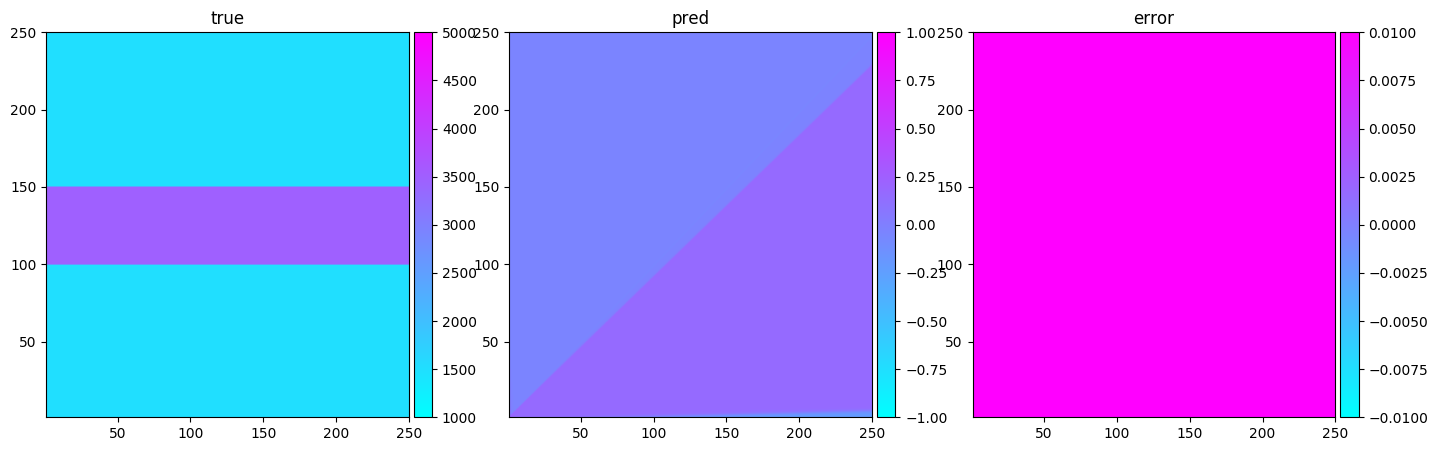

In [10]:
x_test = np.linspace(1.0, 250.0, 250)
z_test = np.linspace(1.0, 250.0, 499)
xz_test = tensor_grid([x_test, z_test])

c_pred = inverse_model(tf.constant(xz_test, dtype = tf.float32))
def c_func(x, z):
	return np.piecewise(z, [z > 150, (z >= 100) & (z <= 150), z < 100], [1500, 3500, 1500])
c_true = c_func(xz_test[:, 0:1], xz_test[:, 1:2])

import matplotlib as mpl
from matplotlib.cm import cool
from matplotlib.colors import Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap = cool
norm = Normalize(vmin=1000, vmax=5000)

X, Z = np.meshgrid(x_test, z_test)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax[0].contourf(X, Z, c_true.reshape((len(x_test), len(z_test))).T, cmap = cmap, norm = norm, levels = 100)
ax[0].set_title("true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1, vmax=1)
im1 = ax[1].contourf(X, Z, c_pred.numpy().reshape((len(x_test), len(z_test))).T, cmap = cmap, norm = norm, levels = 100)
ax[1].set_title("pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1e-2, vmax=1e-2)
im2 = ax[2].contourf(X, Z, c_true.reshape((len(x_test), len(z_test))).T-c_pred.numpy().reshape((len(x_test), len(z_test))).T, cmap = cmap, norm = norm, levels = 100)
ax[2].set_title("error")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

plt.show()

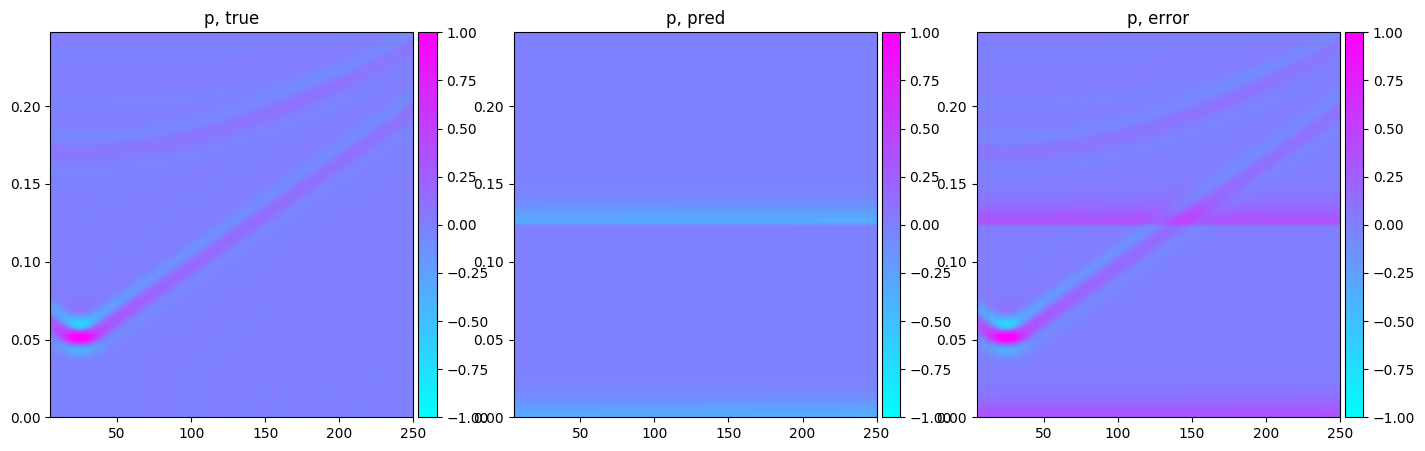

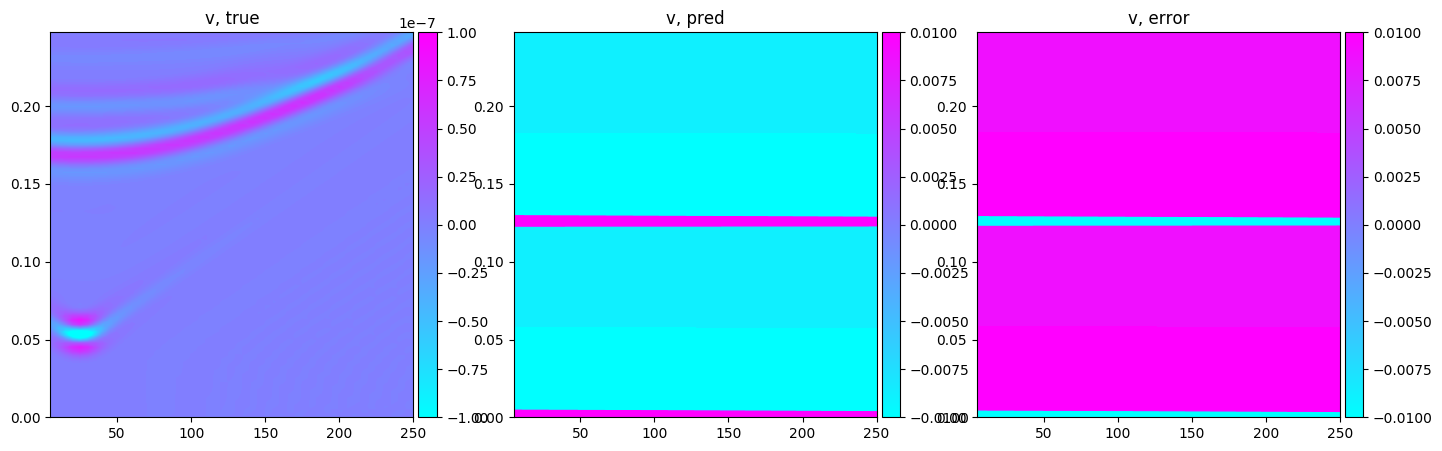

In [14]:
i = 0
p = loadmat("data/sr_p_{}.mat".format(int(x_s[i]/5)))["sr"]*1000
v = loadmat("data/sr_vz_{}.mat".format(int(x_s[i]/5)))["sr"]*1000

x_test = np.linspace(5.0, 250.0, 50)
# z_test = np.linspace(1.0, 250.0, 250)
z_test = [0]
t_test = np.linspace(0.0, 0.2475, 100)
xzt_test = tensor_grid([t_test, x_test, z_test])
xzt_test[:, [0, 1, 2]] = xzt_test[:, [1, 2, 0]]
out = direct_models[i](tf.constant(xzt_test, dtype = tf.float32))

cmap = cool
norm = Normalize(vmin=-1, vmax=1)

X, T = np.meshgrid(x_test, t_test)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax[0].contourf(X, T, p, cmap = cmap, norm = norm, levels = 100)
ax[0].set_title("p, true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = Normalize(vmin=-1, vmax=1)
im1 = ax[1].contourf(X, T, out[:, 0:1].numpy().reshape((len(x_test), len(t_test))).T, cmap = cmap, norm = norm, levels = 100)
ax[1].set_title("p, pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1, vmax=1)
im2 = ax[2].contourf(X, T, p-out[:, 0:1].numpy().reshape((len(x_test), len(t_test))).T, cmap = cmap, norm = norm, levels = 100)
ax[2].set_title("p, error")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')


fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

norm = Normalize(vmin=-1e-7, vmax=1e-7)
im0 = ax[0].contourf(X, T, v, cmap = cmap, norm = norm, levels = 100)
ax[0].set_title("v, true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = Normalize(vmin=-1e-2, vmax=1e-2)
im1 = ax[1].contourf(X, T, out[:, 2:3].numpy().reshape((len(x_test), len(t_test))).T, cmap = cmap, norm = norm, levels = 100)
ax[1].set_title("v, pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1e-2, vmax=1e-2)
im2 = ax[2].contourf(X, T, v-out[:, 2:3].numpy().reshape((len(x_test), len(t_test))).T, cmap = cmap, norm = norm, levels = 100)
ax[2].set_title("v, error")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')
plt.show()

In [ ]:
X.shape

In [ ]:
p.shape